Successfully generated 2185 hourly data points for load profile.

Data split: Training on 2017 hours, Testing on 168 hours (7 days).

--- SARIMA Model ---
Fitting SARIMA model with non-seasonal order (1, 1, 1) and seasonal order (1, 1, 0, 24)...
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2017
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 24)   Log Likelihood               -5754.658
Date:                             Tue, 03 Jun 2025   AIC                          11517.317
Time:                                     13:31:27   BIC                          11539.654
Sample:                                 03-01-2025   HQIC                         11525.525
                                      - 05-24-2025                                         
Covariance Type:                               opg                                         
                 c

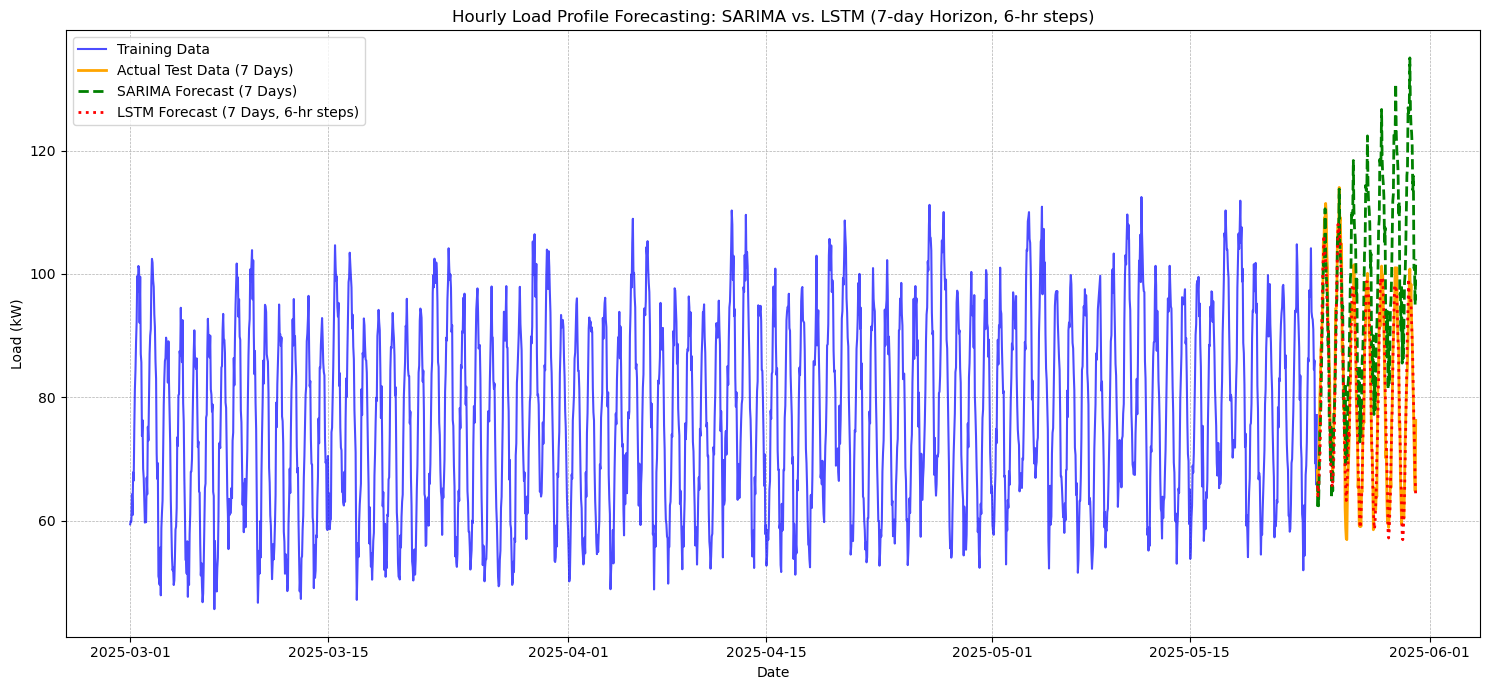

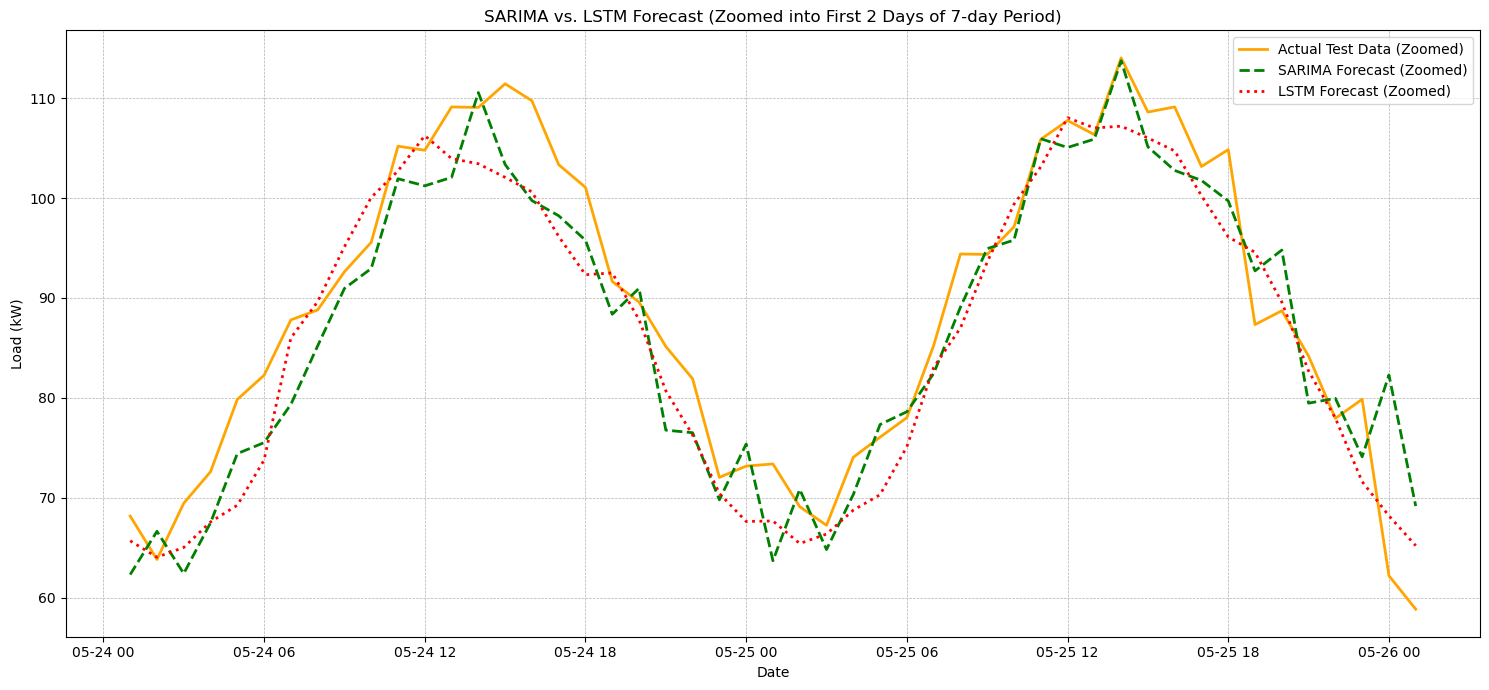


--- Summary of Performance ---
SARIMA (7-day): RMSE = 19.94, MAE = 17.13
LSTM (7-day, 6-hr steps): RMSE = 4.04, MAE = 3.22


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

# Suppress harmless warnings
warnings.filterwarnings("ignore")

# --- 1. Generate Synthetic Hourly Load Profile Data ---
start_date = '2025-03-01'
end_date = '2025-05-31' # 3 months of hourly data
freq = 'H' # Hourly frequency

dates = pd.date_range(start=start_date, end=end_date, freq=freq)
n_points = len(dates)

base_load = 50
hour_of_day = dates.hour.to_numpy()
daily_pattern = (np.sin((hour_of_day - 8) * np.pi / 12) + 1) * 20

day_of_week = dates.dayofweek.to_numpy()
weekly_pattern = np.where(day_of_week < 5, 0, 10)

trend = np.linspace(0, 10, n_points)
noise = np.random.normal(0, 3, n_points)

load = np.array(base_load + daily_pattern + weekly_pattern + trend + noise)
load[load < 0] = 0

load_profile = pd.Series(load, index=dates)

print(f"Successfully generated {len(load_profile)} hourly data points for load profile.")

# --- 2. Visualize the Synthetic Data (Optional) ---
# (Code omitted for brevity)

# --- 3. Prepare Data for Modeling (SARIMA & LSTM) ---
# Split the data into training and testing sets
test_period_hours = 7 * 24 
train_size = len(load_profile) - test_period_hours
train_data = load_profile[:train_size]
test_data = load_profile[train_size:] # This is our 7-day actual data for evaluation

print(f"\nData split: Training on {len(train_data)} hours, Testing on {len(test_data)} hours (7 days).")

# Define the number of hours you want to forecast ahead IN EACH STEP (for LSTM)
# And the 'horizon' for SARIMA's continuous forecast
FORECAST_STEP_HORIZON = 6 

# --- 4. SARIMA Model Training and Forecasting ---
print("\n--- SARIMA Model ---")
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 24) # Daily seasonality (24 hours)

print(f"Fitting SARIMA model with non-seasonal order {order} and seasonal order {seasonal_order}...")

sarima_model = SARIMAX(train_data,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())

# Generate SARIMA forecasts for the entire 7-day test period directly
# dynamic=True ensures that SARIMA uses its own previous predictions for subsequent steps
sarima_predictions = sarima_model_fit.predict(start=len(train_data), 
                                               end=len(load_profile) - 1, 
                                               dynamic=True) 
sarima_predictions.index = test_data.index

# Evaluate SARIMA
mse_sarima = mean_squared_error(test_data, sarima_predictions)
rmse_sarima = sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test_data, sarima_predictions)
print(f'SARIMA MSE (7-day forecast): {mse_sarima:.2f}')
print(f'SARIMA RMSE (7-day forecast): {rmse_sarima:.2f}')
print(f'SARIMA MAE (7-day forecast): {mae_sarima:.2f}') # Corrected variable name

# --- 5. LSTM Model Training and Forecasting ---
print("\n--- LSTM Model ---")

# Scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_load = scaler.fit_transform(load_profile.values.reshape(-1, 1))

# Split scaled data
scaled_train_data = scaled_load[:train_size]
scaled_test_data = scaled_load[train_size:]

# Function to create sequences for LSTM
# n_steps_out now corresponds to FORECAST_STEP_HORIZON
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x = data[i:end_ix]
        seq_y = data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in = 24 # Use past 24 hours to predict
n_steps_out = FORECAST_STEP_HORIZON # LSTM predicts 6 hours ahead in each step

# Prepare training data for LSTM
X_train_lstm, y_train_lstm = create_sequences(scaled_train_data, n_steps_in, n_steps_out)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
y_train_lstm = y_train_lstm.reshape(y_train_lstm.shape[0], y_train_lstm.shape[1])


print(f"LSTM training input shape: {X_train_lstm.shape}")
print(f"LSTM training output shape: {y_train_lstm.shape}")

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, 1))) 
lstm_model.add(Dense(n_steps_out)) # Output layer matches n_steps_out (6 values)
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
print("Training LSTM model...")
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=75, batch_size=32, verbose=0) 
print("LSTM model trained.")

# Generate LSTM forecasts for the entire 7-day test period by predicting 6 hours at a time
lstm_predictions_scaled = []

# Calculate the number of 6-hour blocks needed to cover the test data
num_forecast_blocks = int(np.ceil(len(test_data) / FORECAST_STEP_HORIZON))

# The prediction loop now ensures we predict enough blocks
for k in range(num_forecast_blocks):
    # Determine the start and end indices in the *overall scaled_load array*
    # for the current input window to the LSTM.
    # This input window should precede the block of data we are about to predict.
    
    # Example: If k=0, we're predicting the first block of test_data.
    # The input window should end at train_size-1. Its start is train_size-n_steps_in.
    # So, input_window_end_overall_idx = train_size + k * FORECAST_STEP_HORIZON (i.e., train_size for k=0)
    input_window_end_overall_idx = train_size + k * FORECAST_STEP_HORIZON
    input_window_start_overall_idx = input_window_end_overall_idx - n_steps_in

    # Make sure we don't try to access negative indices (shouldn't happen if train_size is large enough)
    if input_window_start_overall_idx < 0:
        print(f"Warning: Not enough preceding data for full n_steps_in window at block {k}. Adjusting start index.")
        input_window_start_overall_idx = 0 # Or pad with zeros if n_steps_in is much larger than train_size

    # Form the current input batch from the overall scaled_load array
    current_input_batch = scaled_load[input_window_start_overall_idx : input_window_end_overall_idx].reshape(1, n_steps_in, 1)

    # Get the prediction for the next FORECAST_STEP_HORIZON (6) steps
    predicted_steps = lstm_model.predict(current_input_batch, verbose=0)[0] 
    lstm_predictions_scaled.extend(predicted_steps)

# Inverse transform the predictions to original scale
# Crucially, slice `lstm_predictions_scaled` to exactly match `len(test_data)`
# in case `num_forecast_blocks * FORECAST_STEP_HORIZON` is slightly larger than `len(test_data)`
lstm_predictions_raw = np.array(lstm_predictions_scaled[:len(test_data)]).reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions_raw)
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index)
lstm_predictions[lstm_predictions < 0] = 0 # Ensure no negative predictions


# Evaluate LSTM
mse_lstm = mean_squared_error(test_data, lstm_predictions)
rmse_lstm = sqrt(mse_lstm)
mae_lstm = mean_absolute_error(test_data, lstm_predictions)
print(f'LSTM MSE (7-day forecast): {mse_lstm:.2f}')
print(f'LSTM RMSE (7-day forecast): {rmse_lstm:.2f}')
print(f'LSTM MAE (7-day forecast): {mae_lstm:.2f}')


# --- 6. Comparative Visualization of Forecasts ---

plt.figure(figsize=(10, 5)) 
plt.plot(train_data.index, train_data, label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data, label='Actual Test Data (7 Days)', color='orange', linewidth=2)
plt.plot(sarima_predictions.index, sarima_predictions, label=f'SARIMA Forecast (7 Days)', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions.index, lstm_predictions, label=f'LSTM Forecast (7 Days, {FORECAST_STEP_HORIZON}-hr steps)', color='red', linestyle=':', linewidth=2)

plt.title(f'Hourly Load Profile Forecasting: SARIMA vs. LSTM (7-day Horizon, {FORECAST_STEP_HORIZON}-hr steps)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Zoom in on a shorter portion of the forecast period for better visual comparison
# Let's zoom into the first 2 days of the test period
zoom_start_date = test_data.index[0]
zoom_end_date = test_data.index[0] + pd.Timedelta(days=3) # Zoom into the first 2 days

plt.figure(figsize=(10, 5)) 
plt.plot(test_data[zoom_start_date:zoom_end_date].index, test_data[zoom_start_date:zoom_end_date], label='Actual Test Data (Zoomed)', color='orange', linewidth=2)
plt.plot(sarima_predictions[zoom_start_date:zoom_end_date].index, sarima_predictions[zoom_start_date:zoom_end_date], label=f'SARIMA Forecast (Zoomed)', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions[zoom_start_date:zoom_end_date].index, lstm_predictions[zoom_start_date:zoom_end_date], label=f'LSTM Forecast (Zoomed)', color='red', linestyle=':', linewidth=2)
plt.title(f'SARIMA vs. LSTM Forecast (Zoomed into First 2 Days of 7-day Period)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance ---")
print(f"SARIMA (7-day): RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM (7-day, {FORECAST_STEP_HORIZON}-hr steps): RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")

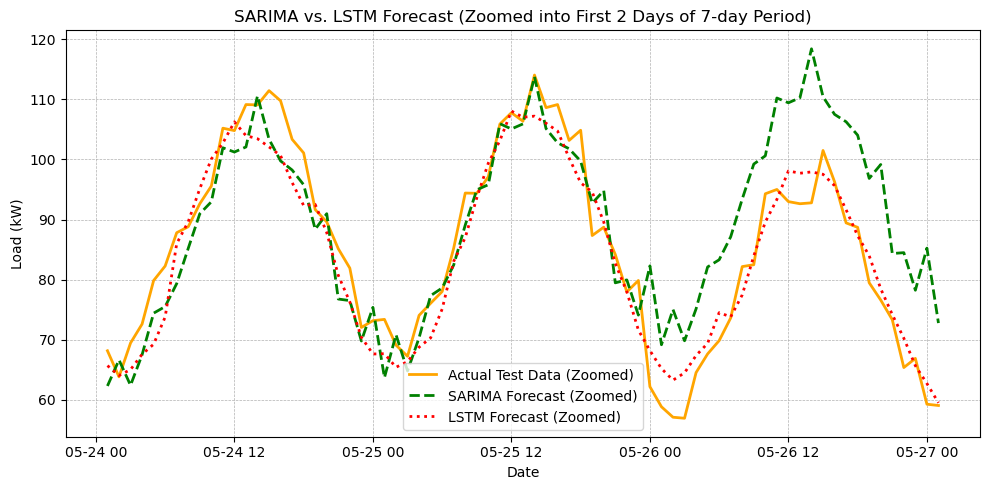


--- Summary of Performance ---
SARIMA (7-day): RMSE = 19.94, MAE = 17.13
LSTM (7-day, 6-hr steps): RMSE = 4.04, MAE = 3.22


In [10]:
# Zoom in on a shorter portion of the forecast period for better visual comparison
# Let's zoom into the first 2 days of the test period
zoom_start_date = test_data.index[0]
zoom_end_date = test_data.index[0] + pd.Timedelta(days=3) # Zoom into the first 2 days

plt.figure(figsize=(10, 5)) 
plt.plot(test_data[zoom_start_date:zoom_end_date].index, test_data[zoom_start_date:zoom_end_date], label='Actual Test Data (Zoomed)', color='orange', linewidth=2)
plt.plot(sarima_predictions[zoom_start_date:zoom_end_date].index, sarima_predictions[zoom_start_date:zoom_end_date], label=f'SARIMA Forecast (Zoomed)', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions[zoom_start_date:zoom_end_date].index, lstm_predictions[zoom_start_date:zoom_end_date], label=f'LSTM Forecast (Zoomed)', color='red', linestyle=':', linewidth=2)
plt.title(f'SARIMA vs. LSTM Forecast (Zoomed into First 2 Days of 7-day Period)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance ---")
print(f"SARIMA (7-day): RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM (7-day, {FORECAST_STEP_HORIZON}-hr steps): RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")

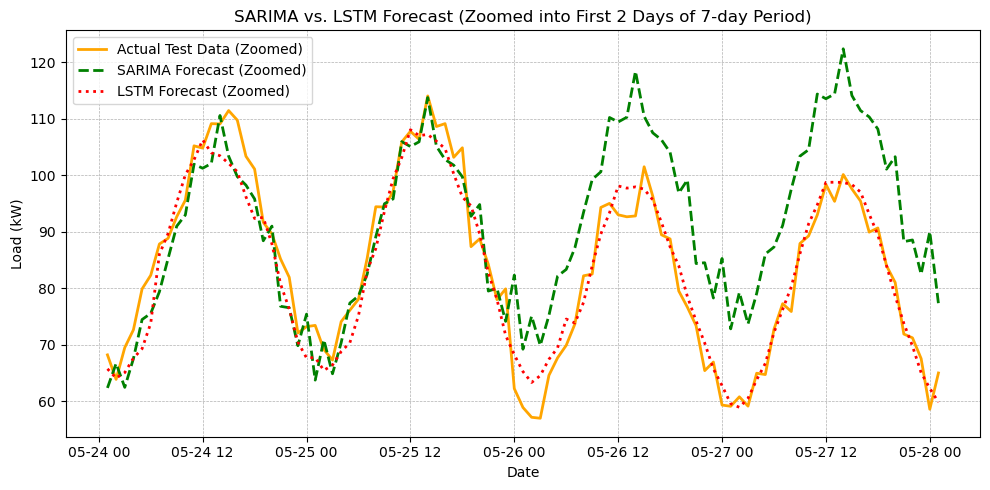


--- Summary of Performance ---
SARIMA (7-day): RMSE = 19.94, MAE = 17.13
LSTM (7-day, 6-hr steps): RMSE = 4.04, MAE = 3.22


In [11]:
# Zoom in on a shorter portion of the forecast period for better visual comparison
# Let's zoom into the first 2 days of the test period
zoom_start_date = test_data.index[0]
zoom_end_date = test_data.index[0] + pd.Timedelta(days=4) # Zoom into the first 2 days

plt.figure(figsize=(10, 5)) 
plt.plot(test_data[zoom_start_date:zoom_end_date].index, test_data[zoom_start_date:zoom_end_date], label='Actual Test Data (Zoomed)', color='orange', linewidth=2)
plt.plot(sarima_predictions[zoom_start_date:zoom_end_date].index, sarima_predictions[zoom_start_date:zoom_end_date], label=f'SARIMA Forecast (Zoomed)', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions[zoom_start_date:zoom_end_date].index, lstm_predictions[zoom_start_date:zoom_end_date], label=f'LSTM Forecast (Zoomed)', color='red', linestyle=':', linewidth=2)
plt.title(f'SARIMA vs. LSTM Forecast (Zoomed into First 2 Days of 7-day Period)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance ---")
print(f"SARIMA (7-day): RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM (7-day, {FORECAST_STEP_HORIZON}-hr steps): RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")

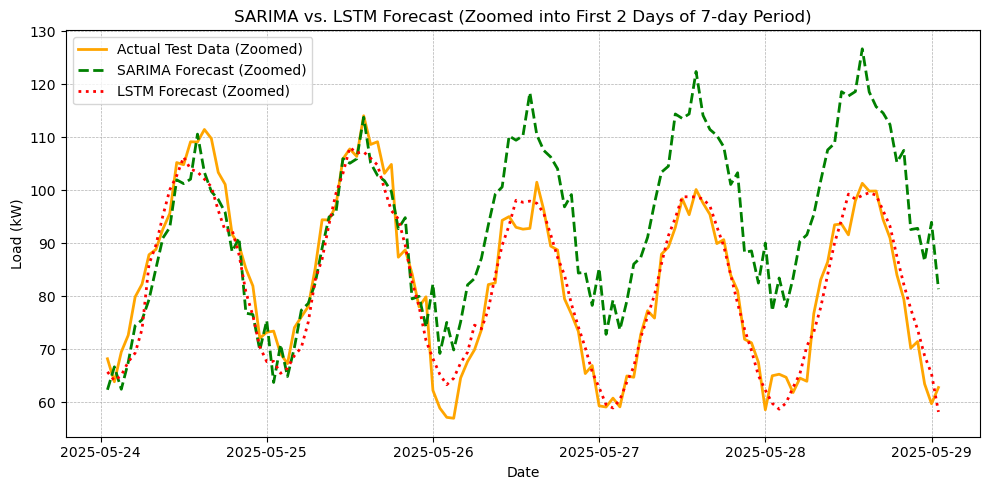


--- Summary of Performance ---
SARIMA (7-day): RMSE = 19.94, MAE = 17.13
LSTM (7-day, 6-hr steps): RMSE = 4.04, MAE = 3.22


In [12]:
# Zoom in on a shorter portion of the forecast period for better visual comparison
# Let's zoom into the first 2 days of the test period
zoom_start_date = test_data.index[0]
zoom_end_date = test_data.index[0] + pd.Timedelta(days=5) # Zoom into the first 2 days

plt.figure(figsize=(10, 5)) 
plt.plot(test_data[zoom_start_date:zoom_end_date].index, test_data[zoom_start_date:zoom_end_date], label='Actual Test Data (Zoomed)', color='orange', linewidth=2)
plt.plot(sarima_predictions[zoom_start_date:zoom_end_date].index, sarima_predictions[zoom_start_date:zoom_end_date], label=f'SARIMA Forecast (Zoomed)', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions[zoom_start_date:zoom_end_date].index, lstm_predictions[zoom_start_date:zoom_end_date], label=f'LSTM Forecast (Zoomed)', color='red', linestyle=':', linewidth=2)
plt.title(f'SARIMA vs. LSTM Forecast (Zoomed into First 2 Days of 7-day Period)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance ---")
print(f"SARIMA (7-day): RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM (7-day, {FORECAST_STEP_HORIZON}-hr steps): RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")